# Plots for Paper

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

from src.utils.utils import plot_hist, block_mean, block_std, get_energy
from src.utils.montecarlo import neural_mcmc, hybrid_mcmc, seq_hybrid_mcmc, single_spin_flip

## Correlation and thermalization

We focused on the system with 484 spins and 1NN couplings, in this scenario we observe a significative boosting when using the neural network inside the Monte Carlo methods as a smart proposal.
We called this  procedure *Neural Markov Chain Monte Carlo (Neural MCMC)*. In this method the Metropolis-Hastings acceptance rate becomes
$$
A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{p(\mathbf{\sigma}')\omega_{\mathbf{\sigma}\mathbf{\sigma}'}}{p(\mathbf{\sigma})\omega_{\mathbf{\sigma}'\mathbf{\sigma}}}\right).

In [41]:
spin_side = 22
couplings_path = "data/couplings/484spins-uniform-1nn.txt"
spins = spin_side**2
beta = 3.5
# seed for standard point 
seeds = [2353415, 5983276, 587346, 45907345, 439016]
steps=1000000

Here we collect some Single Spin Flip MCMC, starting from differet initial configuration. 

In [14]:
engs=[]
for seed in seeds:
    engs.append(single_spin_flip(spins, beta, steps, couplings_path, seed=seed, disable_bar=True)[1])
engs = np.asarray(engs) / spins


Start MCMC simulation
beta=3.5 seed=2353415

MCMC: Beta=3.5 Seed=2353415
Steps: 1000000  A_r=3.91%  E=-0.718879 ± 0.000016  [σ=0.015626  E_min=-0.740872]
Duration 0:00:11.358105

Start MCMC simulation
beta=3.5 seed=5983276

MCMC: Beta=3.5 Seed=5983276
Steps: 1000000  A_r=4.07%  E=-0.720657 ± 0.000016  [σ=0.016295  E_min=-0.737404]
Duration 0:00:10.831151

Start MCMC simulation
beta=3.5 seed=587346

MCMC: Beta=3.5 Seed=587346
Steps: 1000000  A_r=4.82%  E=-0.710397 ± 0.000021  [σ=0.020761  E_min=-0.731739]
Duration 0:00:10.767253

Start MCMC simulation
beta=3.5 seed=45907345

MCMC: Beta=3.5 Seed=45907345
Steps: 1000000  A_r=4.33%  E=-0.721755 ± 0.000014  [σ=0.014316  E_min=-0.736682]
Duration 0:00:10.680158

Start MCMC simulation
beta=3.5 seed=439016

MCMC: Beta=3.5 Seed=439016
Steps: 1000000  A_r=4.19%  E=-0.718625 ± 0.000019  [σ=0.018990  E_min=-0.737033]
Duration 0:00:10.694600


Then we compare with the data generated by the neural network, an autoregressive model called **MADE** (**M**asked **A**utoregressive **D**ensity **E**stimator), in this case.

In [15]:
dataset = [
        "data/generated/sample-400000_size-484_2022-01-28_15-48-44.npz", # 1mus 1nn
        "data/generated/sample-400000_size-484_2022-01-28_15-50-01.npz", # 10mus 1nn
        "data/generated/sample-400000_size-484_2022-02-10_11-48-45.npz", # 100mus 1nn
        "data/generated/sample-400000_size-484_2022-02-10_15-28-37.npz", # 1<beta<2.5
        ]

_, eng_neural, ar = neural_mcmc(beta, 400000, dataset[2], couplings_path, "made", disable_bar=True)
eng_neural = eng_neural / spins


Performing Neural MCMC at beta=3.5
Steps: 400000 A_r=2.02%
E=-0.740236 ± 0.000007  [σ=0.004486  E_min=-0.753056]
Duration 0:00:09.159469


First of all, we plot the energy w.r.t the steps of the Markov Chain. For the Single Spin Flip simulations we plot the mean of 5 chains and the shadow of the minimum and the maximum value. 

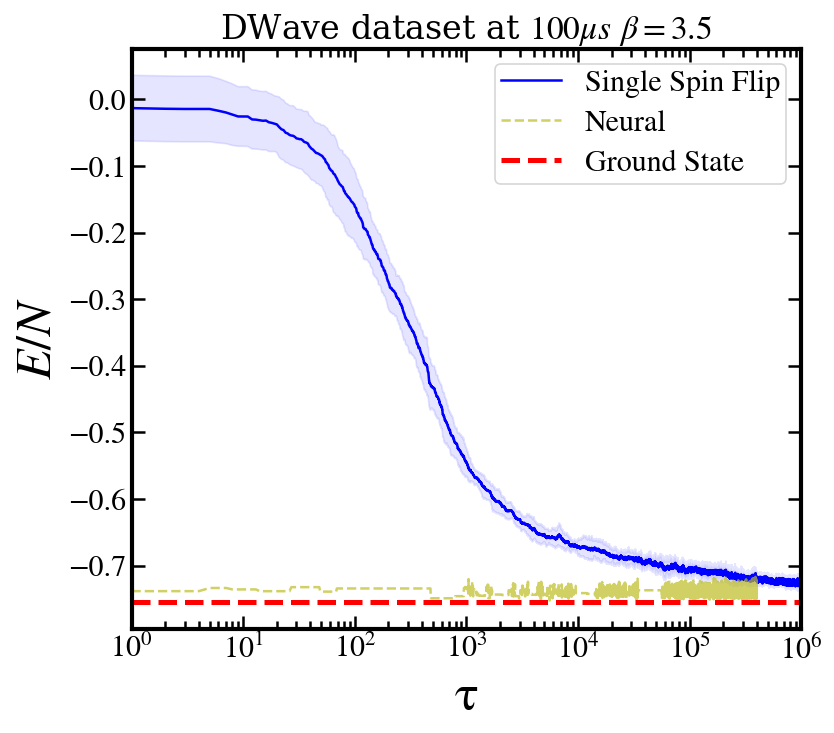

In [16]:
fig, ax = plt.subplots(figsize=(7.2, 6.4), dpi=120)

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 2.5

stringfont = 'serif'

ax.tick_params(axis='y', top=True, right=True, labeltop=False, labelright=False, width=1.5, length=8, direction='in', labelsize=18)
ax.tick_params(axis='x', top=True, right=True, labeltop=False, labelright=False, width=1.5, length=8, direction='in', labelsize=18)
ax.tick_params(which='minor', top=True, right=False, labeltop=False, labelright=False, width=1.5, length=5, direction='in', labelsize=18)


plt.fill_between(np.arange(np.asarray(engs).shape[1]), np.asarray(engs).mean(axis=0) + np.asarray(engs).std(axis=0), np.asarray(engs).mean(axis=0) - np.asarray(engs).std(axis=0),  alpha=0.1, color="b")
plt.plot(np.asarray(engs).mean(axis=0), label=r"Single Spin Flip", color="b", linewidth=1.5)
plt.plot(eng_neural, "--", label=r"Neural", color='tab:olive', alpha=0.7)

ax.set_xscale("log")


plt.hlines(-0.755, xmin=0, xmax=1500000, colors='red', linestyles='dashed', label="Ground State", linewidth=3.)

plt.xlim(1,1000000)

plt.ylabel(r"$E/N$", fontsize=30, fontfamily=stringfont, fontweight='bold')
plt.xlabel(r"$\mathrm{\tau}$", fontsize=30, fontfamily=stringfont, fontweight='bold')

plt.title(r"DWave dataset at $100 \mu s$ $\beta=3.5$", fontsize=20, fontfamily=stringfont)

plt.legend(loc='best', fontsize=18, labelspacing=0.4, borderpad=0.2, fancybox=True)

plt.savefig("images/energy-steps.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight', transparent=False)

Moreover, we can compute the autocorrelation function. The following plot in log scale shows that the autocorreltion time decays at least $10^2$ times faster in the neural than in the single spin flip simulation.

In [19]:
acs = []
for i in range(len(engs)):
    acs.append(acf(engs[i], nlags=engs[0].shape[0], fft=True))
ac_neural = acf(eng_neural, nlags=engs[0].shape[0], fft=True)
acs = np.asarray(acs)

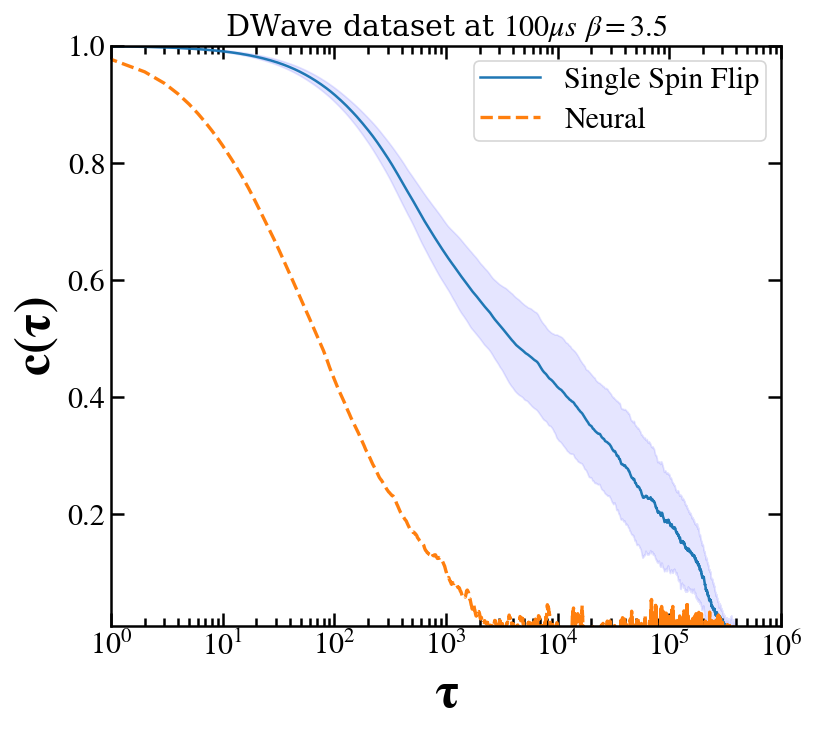

In [24]:
fig, ax = plt.subplots(figsize=(7.2, 6.4), dpi=120)

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 2.5

stringfont = 'serif'

ax.tick_params(axis='y', top=True, right=True, labeltop=False, labelright=False, width=1.5, length=8, direction='in', labelsize=18)
ax.tick_params(axis='x', top=True, right=True, labeltop=False, labelright=False, width=1.5, length=8, direction='in', labelsize=18)
ax.tick_params(which='minor', top=True, right=False, labeltop=False, labelright=False, width=1.5, length=5, direction='in', labelsize=18)

plt.rcParams['axes.linewidth'] = 1.5

plt.plot(acs.mean(0), label=r"Single Spin Flip", linewidth=1.5)
plt.fill_between(np.arange(acs.shape[1]), acs.mean(0) + acs.std(0), acs.mean(0) - acs.std(0), alpha=0.1, color="b")

plt.plot(ac_neural, "--", label=f"Neural", linewidth=2.0)

ax.set_xscale("log")

plt.ylabel(r"$\bf{c(\tau)}$", fontsize=30, fontfamily=stringfont, fontweight='bold')
plt.xlabel(r"$\bf{\tau}$", fontsize=30, fontfamily=stringfont, fontweight='bold')

plt.ylim(0.01, 1)
plt.xlim(1,1000000)

plt.title(r"DWave dataset at $100 \mu s$ $\beta=3.5$", fontsize=18, fontfamily=stringfont)

plt.legend(loc='best', fontsize=18, labelspacing=0.4, borderpad=0.2, fancybox=True)

plt.savefig("images/correlation.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight', transparent=False)

## How DWave works
In the following we describe briefly how the Dwave system works. In particular, we focuse on the choice of the *chains*' strenghts, where the *chains* are the coupled qubits in the quantum annealer that represent a single varible in the original problem. Usually, the DWave sistem's topology doesn't fit exactly the original problem topology, so we need to embed our problem using a heuristic algorithm, generating this kind of *chains*.

Moreover, the annealing time is one of the most imprtant parameter to take in account. In particular low annealing time leads to a noisy solution with many high energy samples. In the following we compare sample obtain with different annealing time or different chains' stringht. Then we show how one can connect the annealing time with an effective $\beta$ in a themodinamic of the lattice. 

In [25]:
dwave_path = "data/sweep_chain_strength/"
strenghts = np.linspace(0.5, 4, 15)

In [26]:
engs = []
for strenght in strenghts:
    engs.append(np.load(f"{dwave_path}dwave-engs_{strenght}.npy"))
engs = np.asarray(engs)

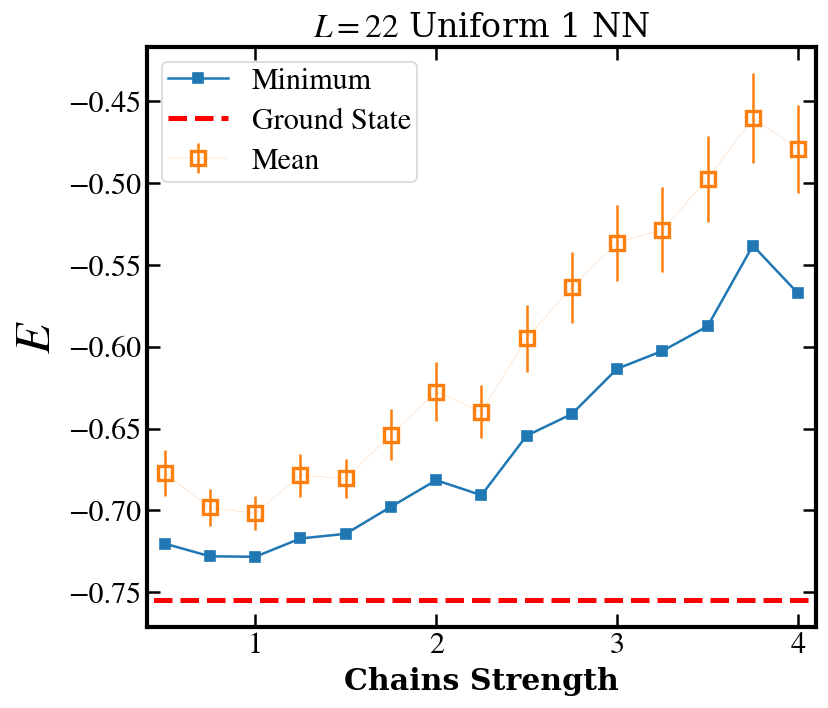

In [44]:
fig, ax = plt.subplots(figsize=(7.2, 6.4), dpi=120)

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 2.5

stringfont = 'serif'

ax.tick_params(axis='y', top=True, right=True, labeltop=False, labelright=False, width=1.5, length=8, direction='in', labelsize=18)
ax.tick_params(axis='x', top=True, right=True, labeltop=False, labelright=False, width=1.5, length=8, direction='in', labelsize=18)

plt.plot(strenghts, engs.min(1) / 484, "-s", label=r"Minimum")
#plt.plot(1.5828847157168355, np.load("data/sweep_chain_strength/dwave-engs_0.npy").min() / 484, "d", color='tab:green', label=f"DWave default")
#plt.errorbar(1.5828847157168355, np.load("data/sweep_chain_strength/dwave-engs_0.npy").mean() / 484, np.load("data/sweep_chain_strength/dwave-engs_0.npy").std() / 484, elinewidth=1.5, linewidth=.1, marker='d', color='tab:green', fillstyle='none', markersize=8, markeredgewidth=2, label=f"DWave default")
plt.errorbar(strenghts, engs.mean(1) / 484, engs.std(1) / 484, elinewidth=1.5, linewidth=.1, marker='s', color='tab:orange', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Mean")

plt.hlines(-365.434418602 / 484, xmin=0, xmax=4.5, colors='red', linestyles='dashed', label="Ground State", linewidth=3)

plt.xlim(0.4, 4.1)

plt.ylabel(r"$E$", fontsize=30, fontfamily=stringfont, fontweight='bold')
plt.xlabel(r"Chains Strength",  fontsize=18, fontfamily=stringfont, fontweight='bold')

plt.title(r"$L=22$ Uniform 1 NN",  fontsize=20, fontfamily=stringfont)

plt.legend(loc='best', fontsize=18, labelspacing=0.4, borderpad=0.2, fancybox=True)

plt.savefig("strenght-energy_uniform.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')